# Output analysis

In [1]:
# Importing external packages

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
# Importing model scripts, by first adding the main folder path

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.model_nile import ModelNile
import plotter

In [3]:
# Change the font type of matplotlib figures to make it match with the report

import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

Let's read the policy and objective value dataframes:

In [4]:
policies = pd.read_csv("merged_dvs.csv")
objectives = pd.read_csv("merged_objectives.csv")

In [5]:
objectives.describe()

,Egypt_irr_def,HAD_min_level,Sudan_irr_def,Ethiopia_hydroenergy
count,1177.000000,1177.000000,1177.000000,1177.000000
mean,1.630644,175.594259,0.000814,13.762701
std,1.139605,2.356408,0.027547,0.358293
min,0.088103,153.048325,0.000000,12.015855
25%,0.692274,174.656189,0.000000,13.526296
50%,1.431588,176.312149,0.000000,13.815966
75%,2.344888,177.272125,0.000000,14.100530
max,6.009802,178.119156,0.945088,14.301876


Query the policies which yield best performance with respect to each objective:

In [6]:
best_obj_indices = dict()
directions = ["min", "max", "min", "max"]

for i, obj in enumerate(objectives):
    if directions[i] == "min":
        indexes = objectives.loc[objectives[obj] == objectives[obj].min(), :].index
    elif directions[i] == "max":
        indexes = objectives.loc[objectives[obj] == objectives[obj].max(), :].index
    else:
        print("issue with directions!")

    best_obj_indices[obj] = indexes

In [7]:
best_obj_indices

{'Egypt_irr_def': Int64Index([973], dtype='int64'),
 'HAD_min_level': Int64Index([93], dtype='int64'),
 'Sudan_irr_def': Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176],
            dtype='int64', length=1094),
 'Ethiopia_hydroenergy': Int64Index([1065], dtype='int64')}

In [8]:
best_egypt_irr = policies.loc[973]
best_egypt_low_had = policies.loc[93]
best_ethiopia = policies.loc[1065]

Before redoing the simulation with found policies, let's do some objectives visualization:

## Parallel Coordinates Plot

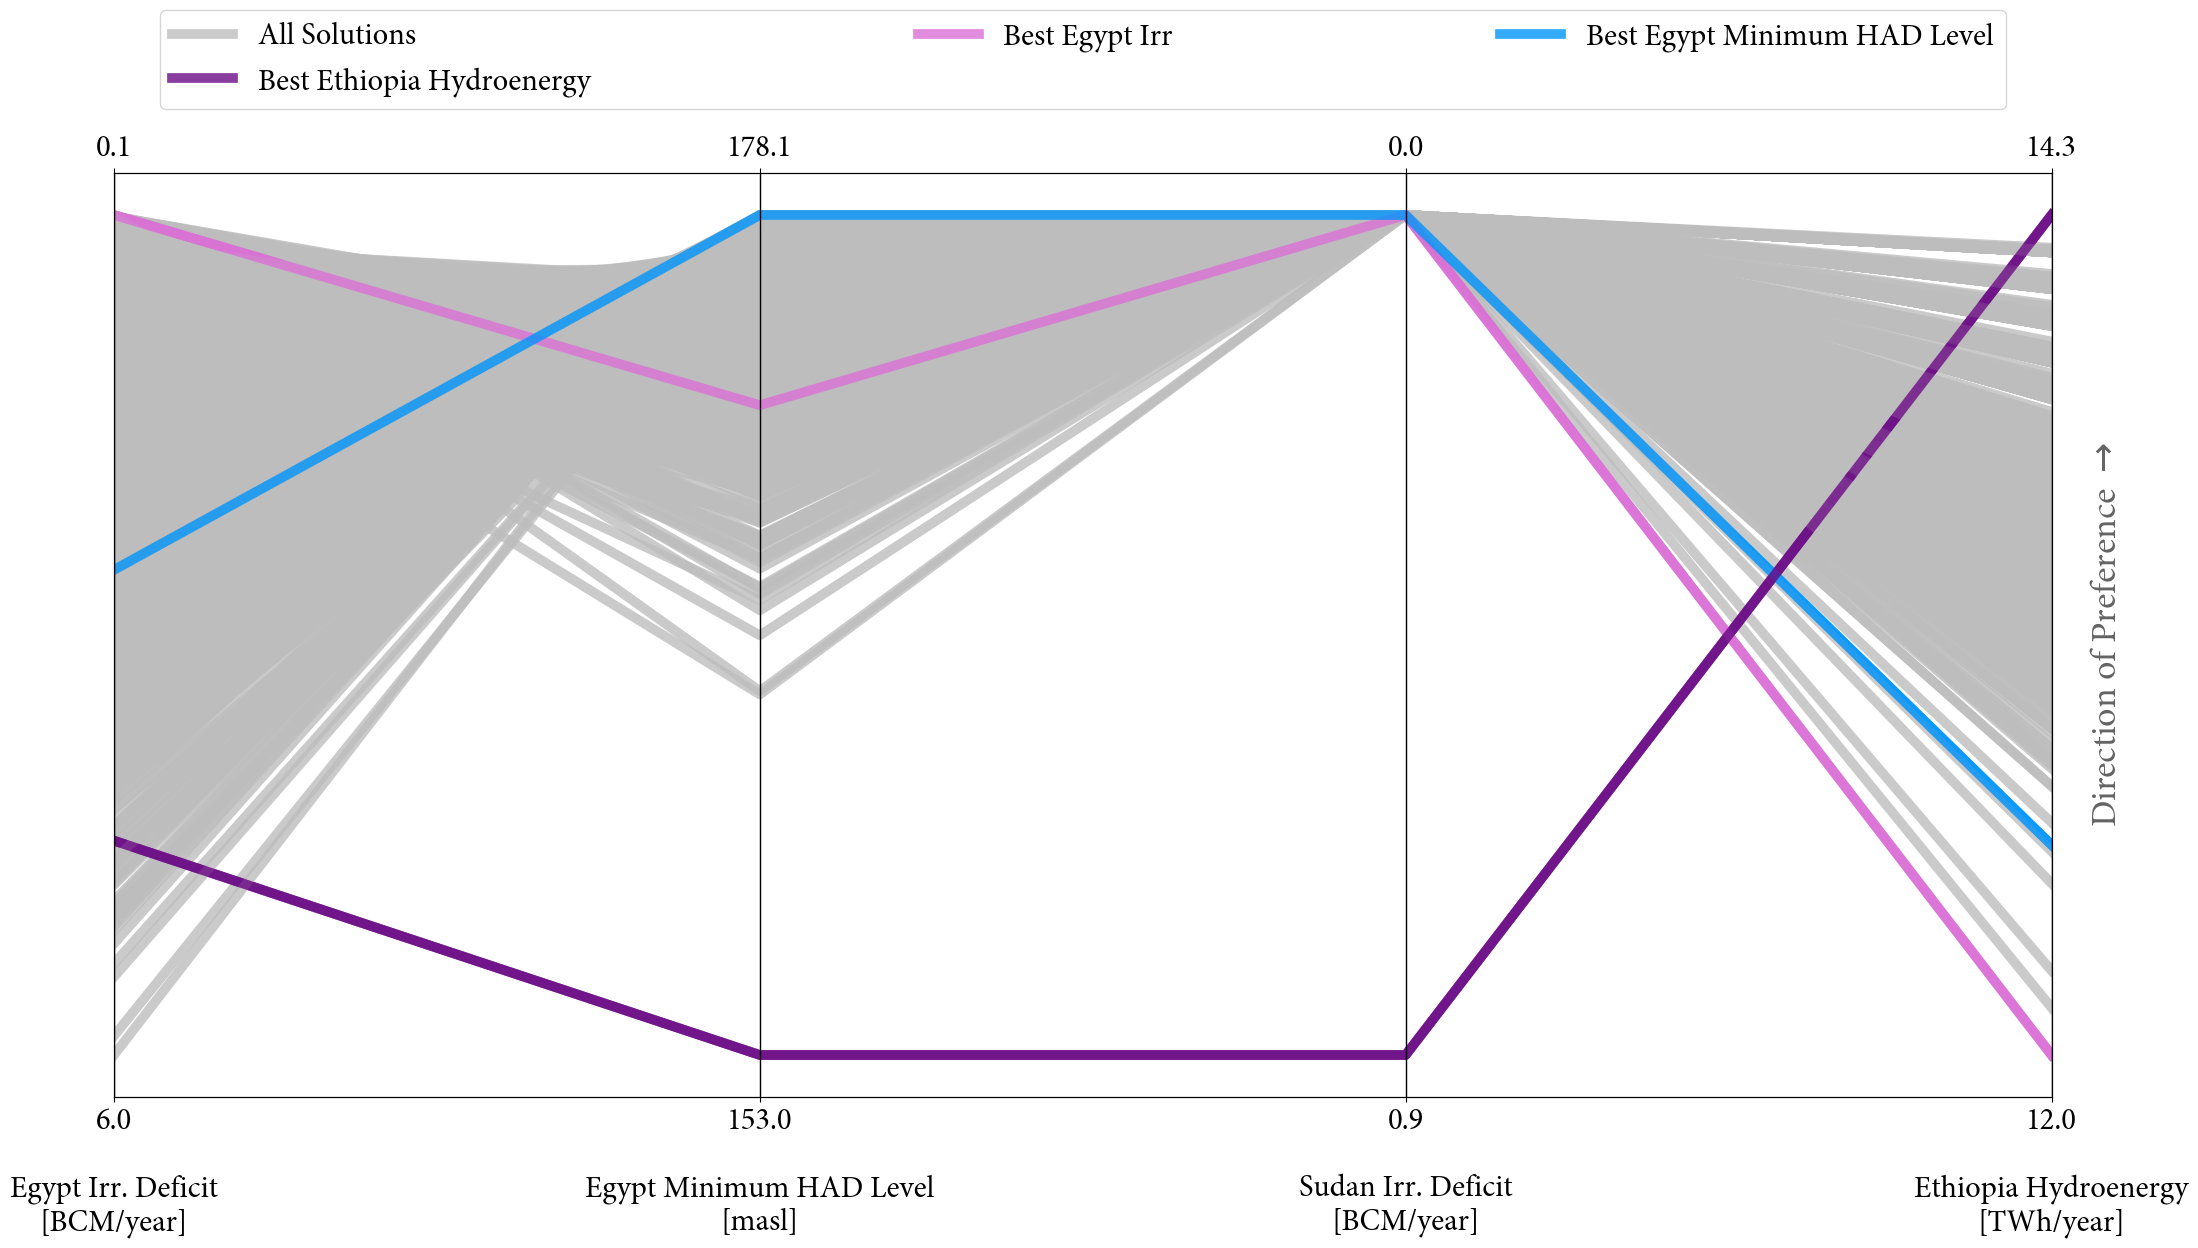

In [9]:
from plotter import parallel_plots_many_policies

parallel_plots_many_policies(
    objectives,
    solution_indices=[973, 93, 1065],
    solution_names=[
        "Best Egypt Irr",
        "Best Egypt Minimum HAD Level",
        "Best Ethiopia Hydroenergy",
    ],
)
plt.show()

In [10]:
def normalize_objs(df, directions):
    desirability_couples = list()
    working_df = df.copy()
    for i, col in enumerate(df.columns):
        if directions[i] == "min":
            best, worst = df[col].min(), df[col].max()
        elif directions[i] == "max":
            best, worst = df[col].max(), df[col].min()
        desirability_couples.append((worst, best))
        working_df[col] = (df[col] - worst) / (best - worst)

    return working_df, desirability_couples

Objective values are normalised such that the most desirable value becomes 1 whilst the least desirable becomes 0. On top of the normalised objectives dataframe, we can find some compromise solutions and include them into the color-coded policy set.

In [11]:
norm_df, desire_couples = normalize_objs(objectives, ["min", "max", "min", "max"])

In [12]:
def find_percentile_compromise_solutions(objectives_norm_df, percentile):
    # Given a threshold percentage and normalised objectives data frame,
    # returns the indices which performs above the threshold percentage
    # for all objectives
    index_lists = []
    for col in objectives_norm_df.columns:
        threshold = np.percentile(objectives_norm_df[col], percentile)
        index_lists.append(
            objectives_norm_df.loc[objectives_norm_df[col] >= threshold, :].index
        )

    common_indices = []
    for i in objectives_norm_df.index:
        counter = 0
        for check_list in index_lists:
            if i not in check_list:
                break
            counter += 1
        if counter == len(index_lists):
            common_indices.append(i)

    return common_indices

In [13]:
def find_threshold_compromise_solutions(objectives_norm_df, threshold):
    # Given a threshold value [0-1] and normalised objectives data frame,
    # returns the indices which performs above the threshold value
    # for all objectives
    index_lists = []
    for col in objectives_norm_df.columns:
        index_lists.append(
            objectives_norm_df.loc[objectives_norm_df[col] >= threshold, :].index
        )

    common_indices = []
    for i in objectives_norm_df.index:
        counter = 0
        for check_list in index_lists:
            if i not in check_list:
                break
            counter += 1
        if counter == len(index_lists):
            common_indices.append(i)

    return common_indices

In [14]:
find_percentile_compromise_solutions(norm_df, 50)

[688]

In [15]:
objectives.loc[688]

Egypt_irr_def             1.390581
HAD_min_level           176.353516
Sudan_irr_def             0.000000
Ethiopia_hydroenergy     13.910079
Name: 688, dtype: float64

In [16]:
find_threshold_compromise_solutions(norm_df, 0.85)

[514]

In [17]:
objectives.loc[514]

Egypt_irr_def             0.878561
HAD_min_level           174.372650
Sudan_irr_def             0.000000
Ethiopia_hydroenergy     14.000287
Name: 514, dtype: float64

Now, we can add two more solutions into the policy set for further analysis:

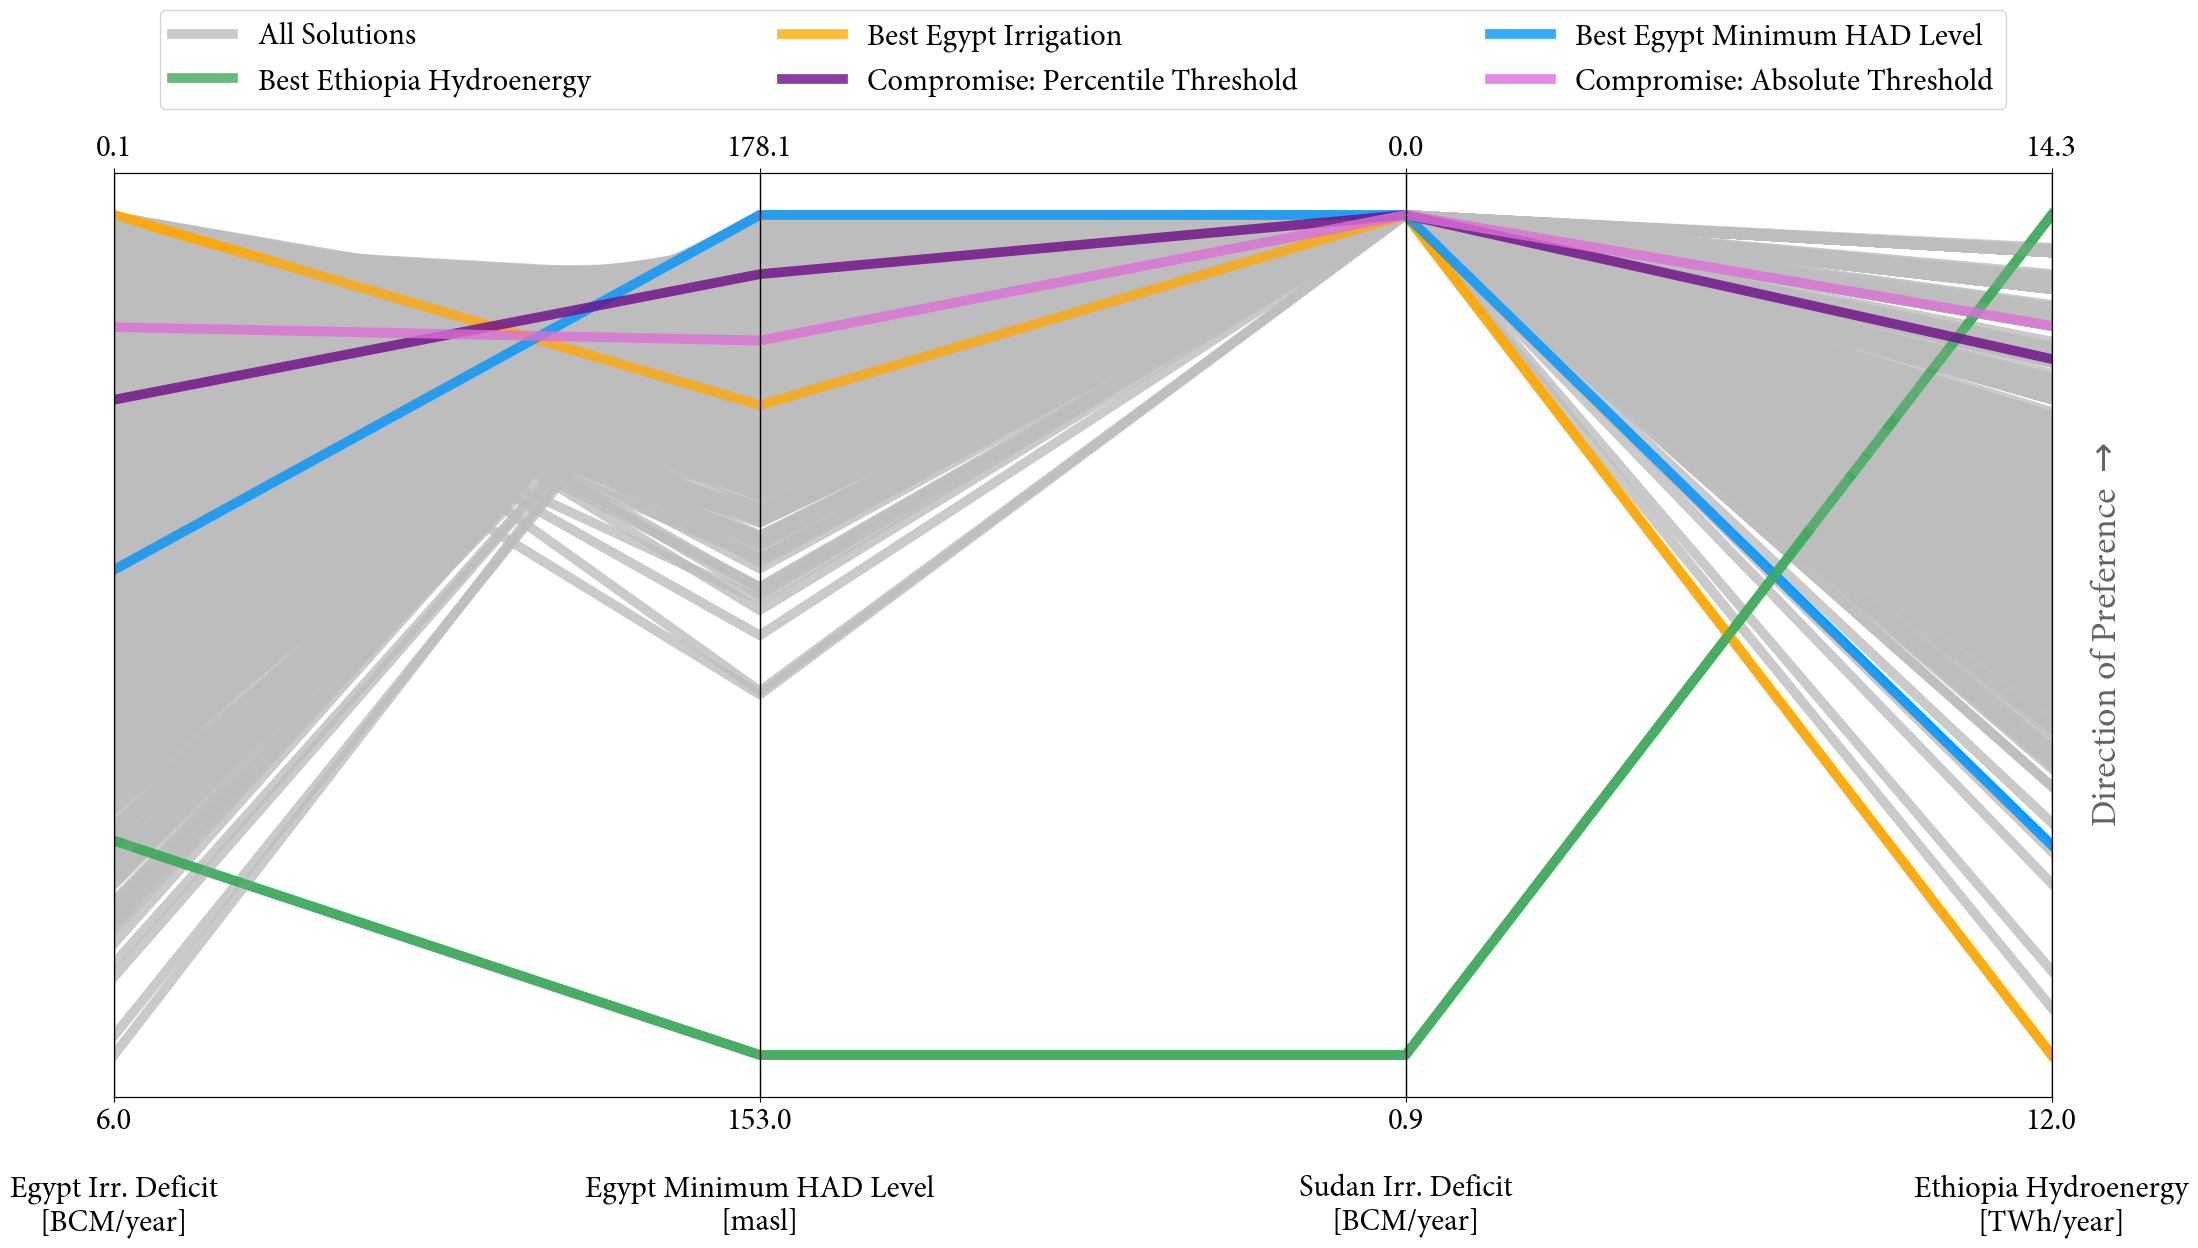

In [18]:
import importlib
import plotter

importlib.reload(plotter)

solution_indices = [973, 93, 1065, 688, 514]
solution_names = [
    "Best Egypt Irrigation",
    "Best Egypt Minimum HAD Level",
    "Best Ethiopia Hydroenergy",
    "Compromise: Percentile Threshold",
    "Compromise: Absolute Threshold",
]

plotter.parallel_plots_many_policies(
    objectives,
    solution_indices=solution_indices,
    solution_names=solution_names,
)

# plt.savefig("../plots/baseline_optimization/parallel_plot.pdf", bbox_inches="tight")
plt.show()

## Pair plot of Objective Values

Now, let's show the pairplot of all objectives across the set of solutions found by the optimisation:

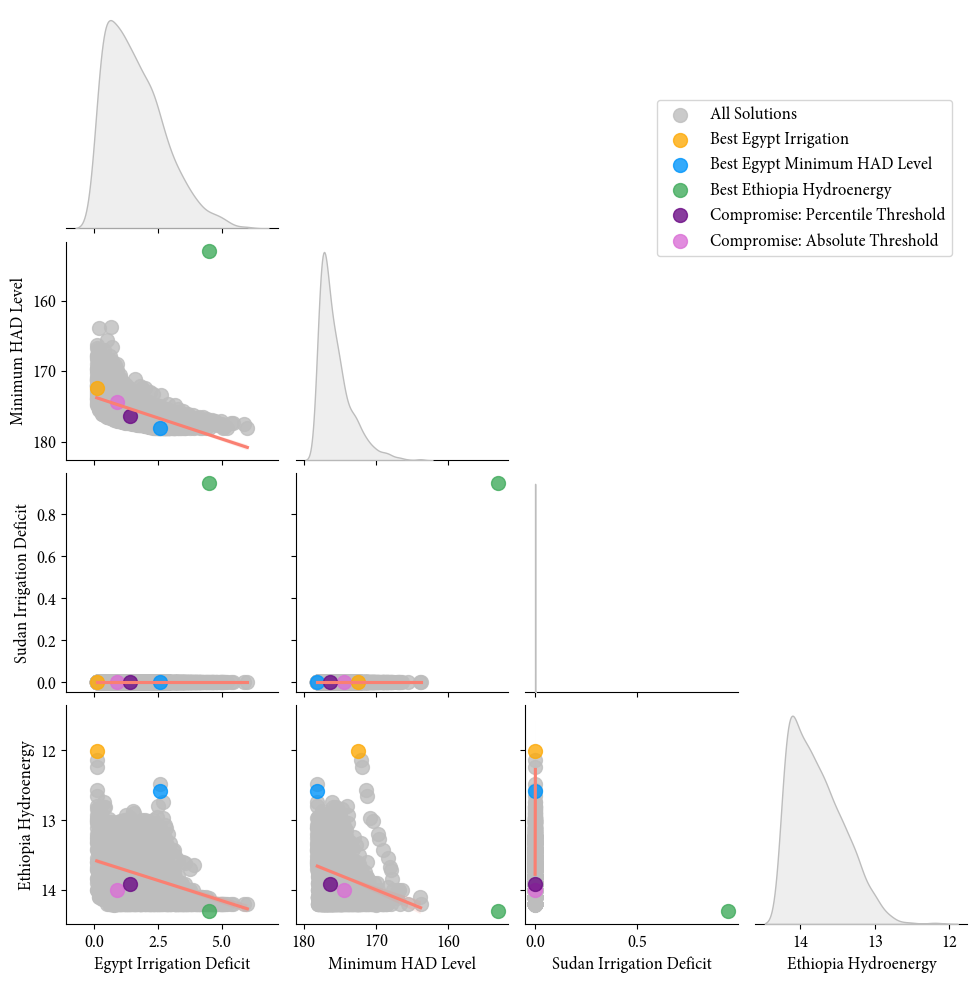

In [19]:
policy_colors = {
    "Best Egypt Irrigation": "#fdaa09",
    "Best Egypt Minimum HAD Level": "#0195fb",
    "Best Ethiopia Hydroenergy": "#41ab5d",
    "Compromise: Percentile Threshold": "#6C0C86",
    "Compromise: Absolute Threshold": "orchid",
    "All Solutions": "#bdbdbd",
}
norm_df = objectives.copy()
norm_df.columns = [
    "Egypt Irrigation Deficit",
    "Minimum HAD Level",
    "Sudan Irrigation Deficit",
    "Ethiopia Hydroenergy",
]


norm_df["Name"] = "All Solutions"
for i, solution_index in enumerate(solution_indices):
    norm_df.loc[solution_index, "Name"] = solution_names[i]
    # norm_df = norm_df.append(norm_df.loc[solution_index, :].copy())

g = sns.pairplot(
    norm_df,
    corner=True,
    kind="reg",
    hue="Name",
    diag_kind="kde",
    plot_kws={"line_kws": {"color": "salmon"}, "scatter_kws": {"s": 100}},
    palette=policy_colors,
)
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()

order = [0, 4, 1, 5, 3, 2]
g.fig.legend(
    handles=[list(handles)[i] for i in order],
    labels=[list(labels)[i] for i in order],
    bbox_to_anchor=(0.75, 0.90),
)
#     for i in range(len(g.axes)-1):
#         g.axes[i,0].invert_yaxis()
#         g.axes[i,i].invert_xaxis()
g.axes[-1, 0].invert_yaxis()
g.axes[1, 0].invert_yaxis()
g.axes[-1, -1].invert_xaxis()
g.axes[-1, 1].invert_xaxis()
# plt.savefig(f"../plots/baseline_optimization/pairplot.pdf", bbox_inches="tight")
plt.show()

For the following stage of open exploration/scenario discovery, we save the six exemplary policies from above analysis:

In [20]:
solution_indices = [973, 93, 1065, 688, 514]
solution_names = [
    "Best Egypt Irrigation",
    "Best Egypt Minimum HAD Level",
    "Best Ethiopia Hydropower",
    "Compromise: Percentile Threshold",
    "Compromise: Absolute Threshold",
]
policies_for_exploration = policies.loc[solution_indices, :]
policies_for_exploration["name"] = solution_names

policies_for_exploration

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v196,v197,v198,v199,v200,v201,v202,v203,v204,name
973,0.063787,0.456172,0.411468,0.963163,0.097215,0.673751,0.335214,-0.182279,0.442914,-0.658328,...,0.033796,0.401708,0.060981,0.139765,0.522041,0.731509,0.222838,0.486961,0.571622,Best Egypt Irrigation
93,0.056767,0.591496,0.643683,0.102761,0.030803,0.946503,0.987958,0.591314,0.784650,0.119132,...,0.454631,0.120220,0.607038,0.202289,1.000000,0.833729,0.339380,0.578749,0.760598,Best Egypt Minimum HAD Level
1065,0.000000,0.214698,0.295648,0.523261,0.454980,1.000000,0.173753,-0.749664,0.004554,-0.715481,...,0.654952,0.777062,0.637723,0.355107,0.673061,0.534431,0.505371,0.275330,0.024209,Best Ethiopia Hydropower
688,0.056161,0.613539,0.510639,0.122278,0.093413,0.368321,0.775546,-0.874330,0.016318,-0.119696,...,0.781552,0.360561,0.211263,0.287920,0.160836,0.646485,0.488403,0.431947,0.609721,Compromise: Percentile Threshold
514,0.059883,0.650205,0.359965,0.122748,0.097466,0.979736,0.696491,-0.821580,0.107872,-0.155530,...,0.581126,0.178435,0.556094,0.556355,0.417923,0.522890,0.532429,0.723748,0.554375,Compromise: Absolute Threshold


In [19]:
# policies_for_exploration.to_csv("../outputs/policies_exploration.csv", index=False)

## System Behaviour under Selected Policies

Let's first create and run a separate model under every one of the policies and store them in a dict. Then, bring the plotter class for visuals.

In [21]:
solution_indices = [973, 93, 1065, 688, 514]
solution_names = [
    "Best Egypt Irrigation",
    "Best Egypt Minimum HAD Level",
    "Best Ethiopia Hydropower",
    "Compromise: Percentile Threshold",
    "Compromise: Absolute Threshold",
]
solutions = [policies.loc[i] for i in solution_indices]
running_models = dict()
for i, sol_name in tqdm(enumerate(solution_names)):
    new_model = ModelNile()
    full_return = new_model.evaluate(solutions[i])
    running_models[sol_name] = full_return

5it [16:18, 195.64s/it]


In [22]:
running_models["Best Ethiopia Hydroenergy"] = running_models["Best Ethiopia Hydropower"]

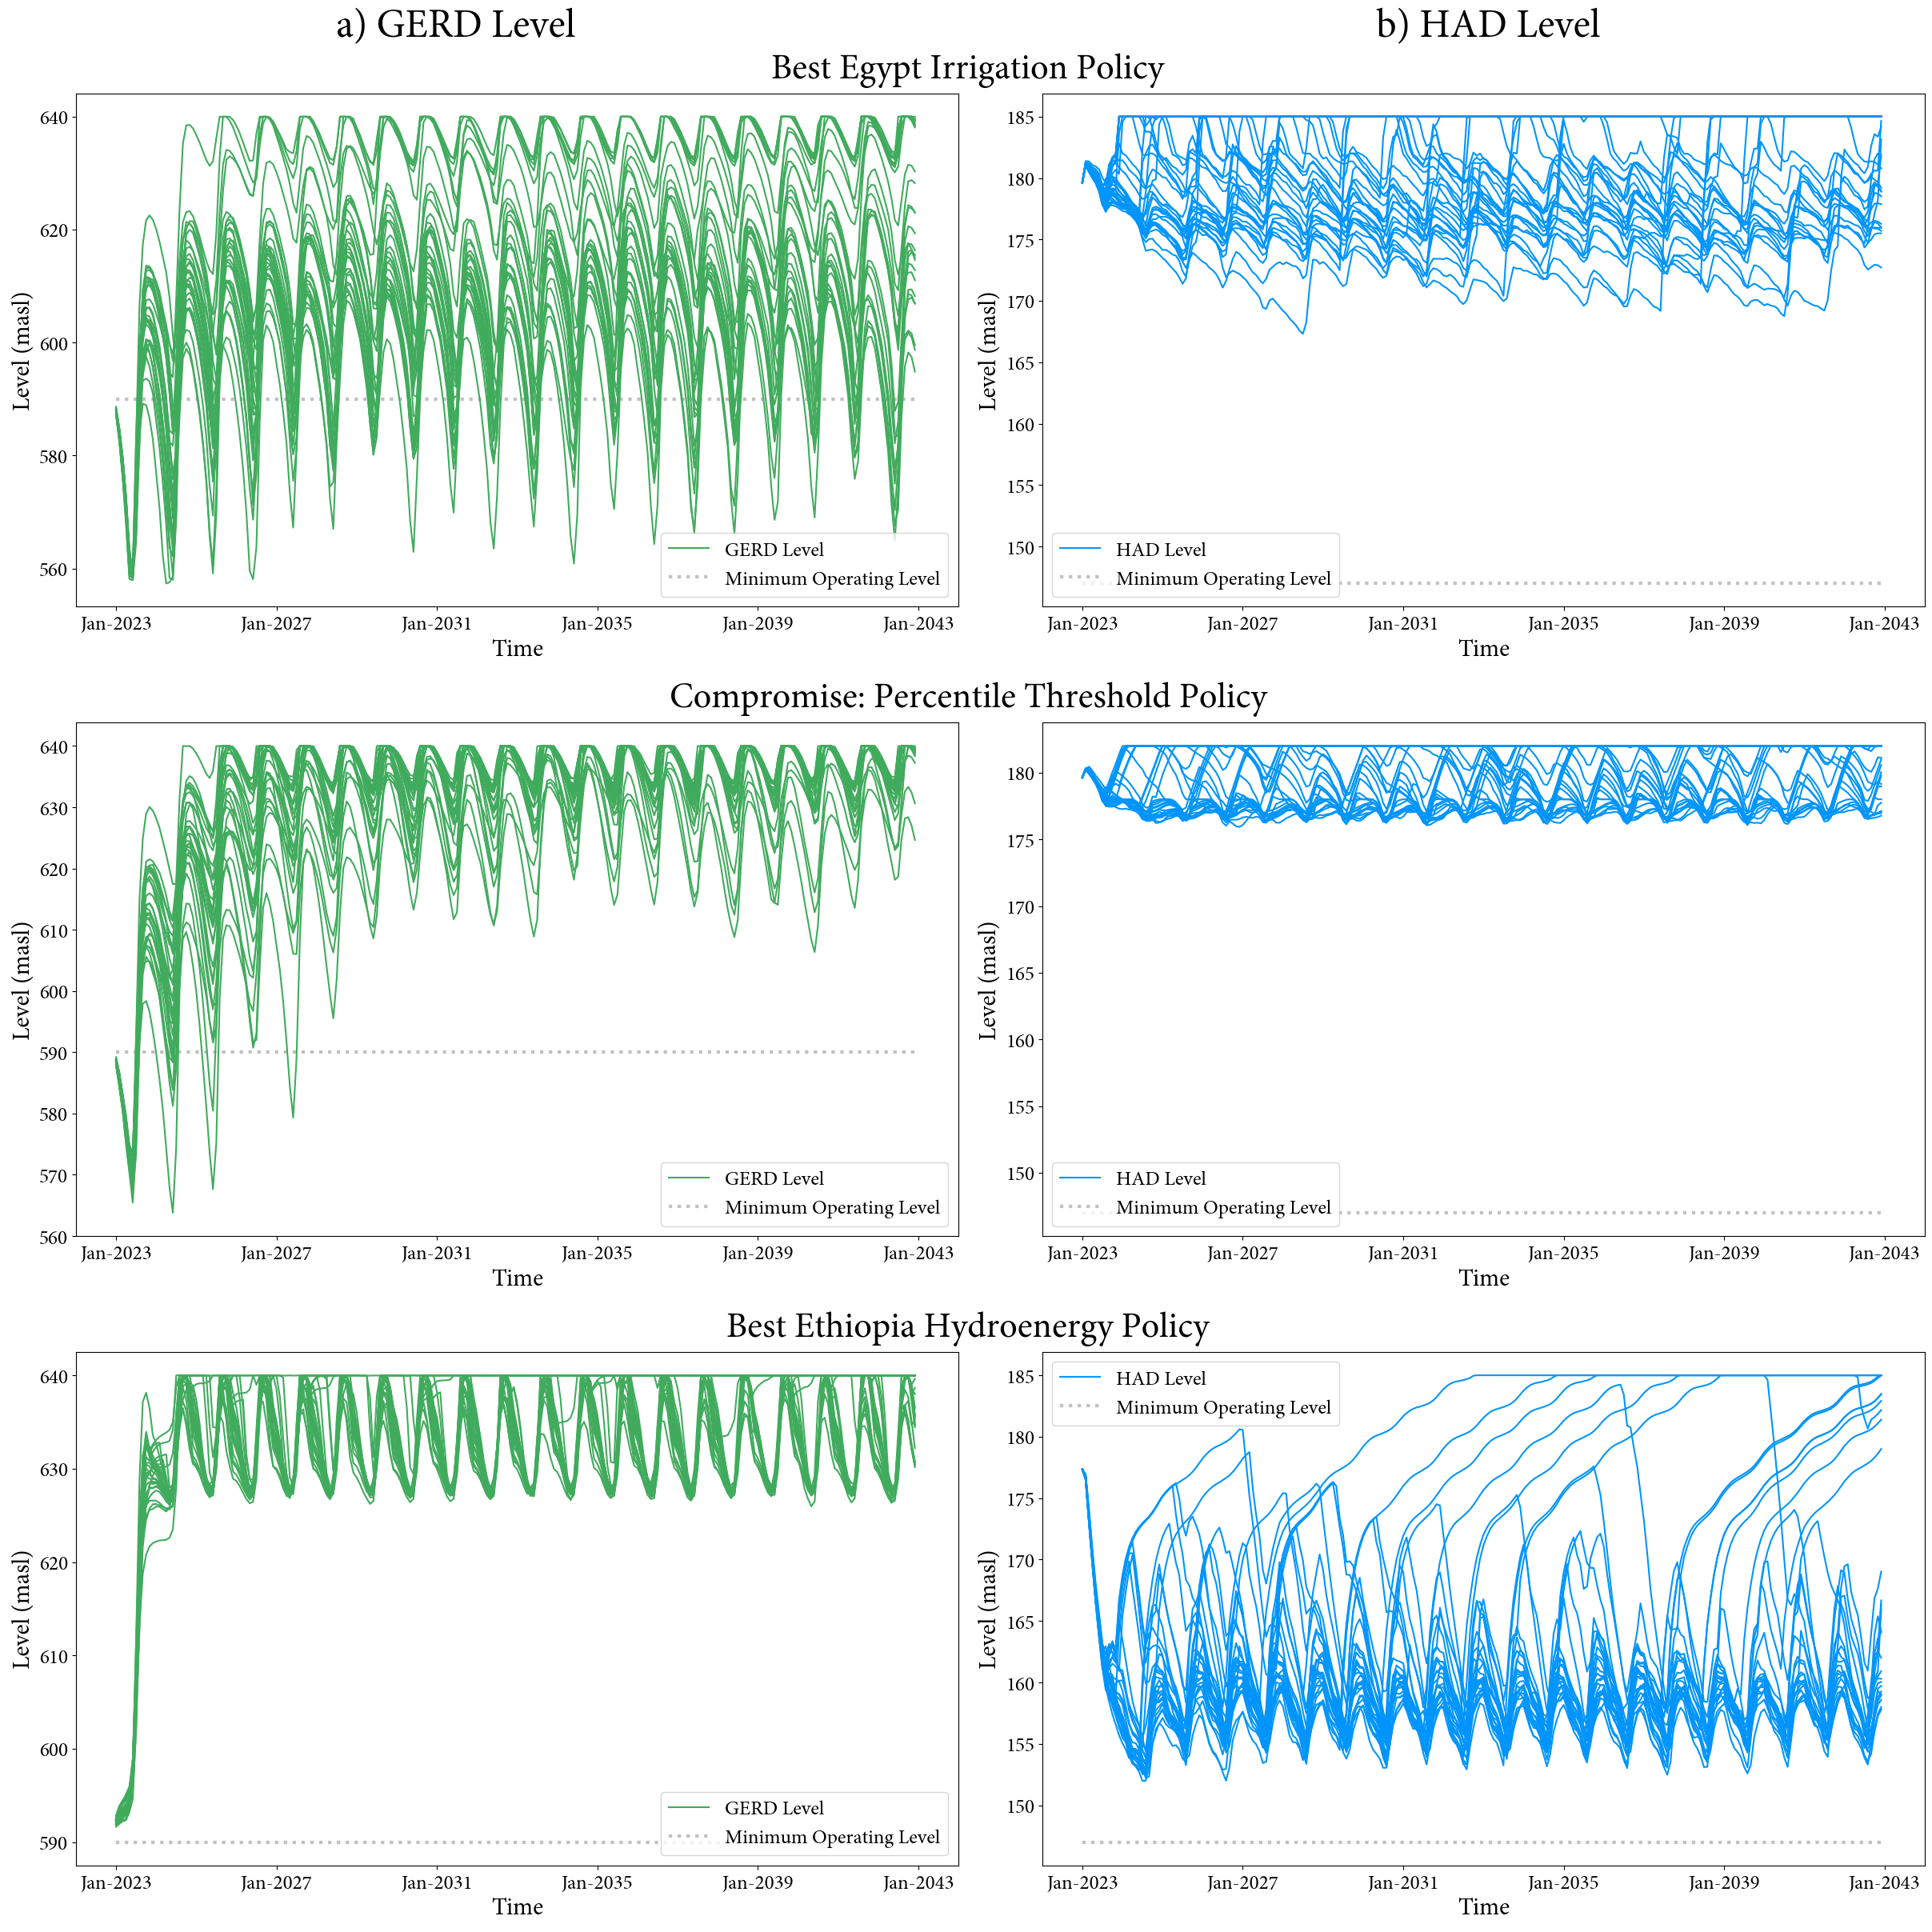

In [23]:
# create 3x1 subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(24,24), constrained_layout=True)
fig.suptitle('a) GERD Level                                                                                        b) HAD Level', fontsize=36)

# clear subplots
for ax in axs:
    ax.remove()
    
# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

policies = [
    "Best Egypt Irrigation",
    "Compromise: Percentile Threshold",
    "Best Ethiopia Hydroenergy",
]

dam_plot_parameters = [
        ("GERD", "#41ab5d", 590, 640),
        ("HAD", "#0195fb", 147, 185),
    ]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'{policies[row]} Policy', fontsize=32)
    
    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    
    for column, ax in enumerate(axs):
        dam, dam_color, mini, maxi = dam_plot_parameters[column]
        
        for key, value in running_models[policies[row]][0].items():
            # print(key)
            if key == 0:
                ax.plot(
                    value[0].object_by_name(dam).level_vector,
                    color=dam_color,
                    label=f"{dam} Level",
                )
            else:
                ax.plot(value[0].object_by_name(dam).level_vector, color=dam_color)

        ax.set_xlabel("Time", fontsize=22)
        ax.set_ylabel("Level (masl)", fontsize=22)
        for i, label, color in [(mini, "Minimum Operating Level", "silver")]:
            ax.hlines(
                y=i,
                linewidth=3,
                xmin=0,
                xmax=240,
                label=label,
                color=color,
                linestyle=":",
            )

        ax.set_xticks(np.arange(0, 20 * 12 + 1, 4 * 12))
        ax.set_xticklabels(
            [f"Jan-{2023+i*4}" for i in range(int(20 / 4) + 1)],
            fontsize=14,
        )
        ax.tick_params(labelsize=18)

        ax.legend(fontsize=18)
        #ax.set_title(titles[row][column], fontsize= 20, fontweight='bold')

plt.savefig(
    f"../plots/baseline_optimization/overall_dams.pdf", bbox_inches="tight"
)
plt.show()



In [44]:
empty_list = []
policy_list = []

for policy in [
    "Best Egypt Irrigation",
    "Compromise: Percentile Threshold",
    "Best Ethiopia Hydropower",
]:
    for replication in range(30):
        empty_list += (
            running_models[policy][0][replication][0]
            .object_by_name("GERD")
            .release_vector
        )
        policy_list += 240 * [policy]

# for replication in range(30):
#     empty_list += list(running_models[policy][0][replication][0].object_by_name("BlueNile").streamflow)
#     policy_list += 240 * ["No GERD"]


my_dict = {"GERD Release": empty_list, "Policy": policy_list}
df = pd.DataFrame.from_dict(my_dict)
month_mod = [(i % 12) + 1 for i in df.index]
df["Month"] = month_mod

In [59]:
empty_list = []
policy_list = []

for policy in [
    "Best Egypt Irrigation",
    "Compromise: Percentile Threshold",
    "Best Ethiopia Hydroenergy",
]:
    for replication in range(30):
        releases = (
            running_models[policy][0][replication][0]
            .object_by_name("GERD")
            .release_vector
        )
        for i in range(12):
            empty_list.append(
                np.mean([release for j, release in enumerate(releases) if j % 12 == i])
            )
            policy_list.append(policy)

for replication in range(30):
    releases = (
        running_models[policy][0][replication][0].object_by_name("BlueNile").streamflow
    )
    for i in range(12):
        empty_list.append(
            np.mean([release for j, release in enumerate(releases) if j % 12 == i])
        )
        policy_list.append("No GERD")


my_dict = {"GERD Release": empty_list, "Policy": policy_list}
df = pd.DataFrame.from_dict(my_dict)
month_mod = [(i % 12) + 1 for i in df.index]
df["Month"] = month_mod

In [60]:
df

,GERD Release,Policy,Month
0,1036.376492,Best Egypt Irrigation,1
1,1037.452090,Best Egypt Irrigation,2
2,1048.947162,Best Egypt Irrigation,3
3,1063.948859,Best Egypt Irrigation,4
4,1199.455603,Best Egypt Irrigation,5
...,...,...,...
1435,5283.323043,No GERD,8
1436,4310.824115,No GERD,9
1437,2373.663046,No GERD,10
1438,997.193635,No GERD,11


In [61]:
from matplotlib.patches import PathPatch


def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5 * (xmin + xmax)
                xhalf = 0.5 * (xmax - xmin)

                # setting new width of box
                xmin_new = xmid - fac * xhalf
                xmax_new = xmid + fac * xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

<ipython-input-61-99aaf6848be0>:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


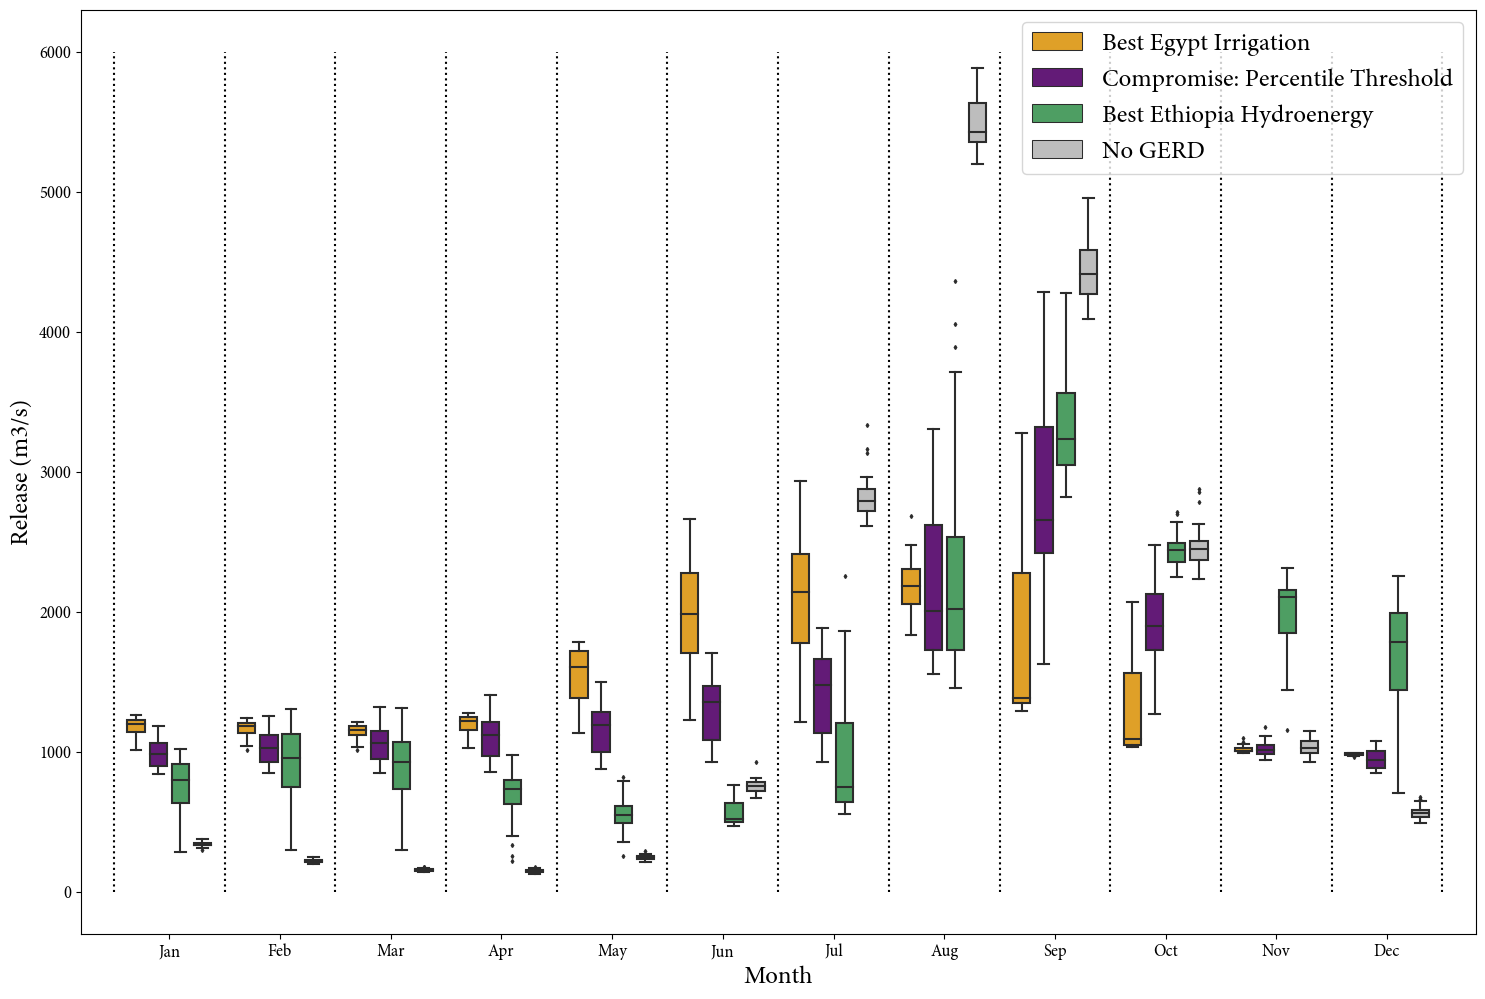

In [62]:
policy_colors = {
    "Best Egypt Irrigation": "#fdaa09",
    "Best Egypt Minimum HAD Level": "#0195fb",
    "Best Ethiopia Hydroenergy": "#41ab5d",
    "Compromise: Percentile Threshold": "#6C0C86",
    "Compromise: Absolute Threshold": "orchid",
    "All Solutions": "#bdbdbd",
    "No GERD": "#bdbdbd",
}
fig, ax = plt.subplots(figsize=(18, 12))
sns.boxplot(
    data=df,
    x="Month",
    y="GERD Release",
    hue="Policy",
    orient="v",
    whis=1.5,
    fliersize=2,
    palette=policy_colors,
)
adjust_box_widths(fig, 0.8)
month_list = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
ax.set_xticklabels(month_list)
ax.set_ylabel("Release (m3/s)", fontsize=18)
ax.set_xlabel("Month", fontsize=18)
ax.vlines(
    x=[i + 0.5 for i in range(-1, 12)],
    ymin=0,
    ymax=6000,
    linestyles="dotted",
    colors="black",
)

ax.legend(fontsize=18)
plt.savefig(
    "../plots/baseline_optimization/GERD_release_boxplots.pdf", bbox_inches="tight"
)
plt.show()

In [129]:
def deneme(**liste):
    print(liste.values())


deneme(a=1, b=2, c=3, d=4, e=5)

dict_values([1, 2, 3, 4, 5])


In [ ]:
import importlib

importlib.reload(plotter)

for key, value in running_models.items():
    print("----------------")
    print(key)
    print("----------------")
    my_plotter = plotter.HydroModelPlotter(value)

    for dam in ["GERD", "HAD"]:
        my_plotter.plot_condensed_release_versus_inflow(dam)
        plt.savefig(
            f"../plots/baseline_optimization/{dam}/release_vs_inflow_{key}_policy.svg",
        )  # bbox_inches="tight")
        plt.show()

        my_plotter.plot_condensed_level(dam)
        plt.savefig(
            f"../plots/baseline_optimization/{dam}/condensed_level_{key}_policy.svg",
        )  # bbox_inches="tight")
        plt.show()

        my_plotter.plot_level_with_limits(dam)
        plt.savefig(
            f"../plots/baseline_optimization/{dam}/level_with_limits_{key}_policy.svg",
        )  # bbox_inches="tight")
        plt.show()

    for district in ["Egypt", "Gezira"]:
        my_plotter.plot_received_vs_demand_for_district_raw_condensed(district)
        plt.savefig(
            f"../plots/baseline_optimization/{district}/received_vs_demand_{key}_policy.svg",
        )  # bbox_inches="tight")
        plt.show()